# Stein Variational Inference

An implementation of regular Stein Variational Gradient Descent ([Lui & Wang, 2016](https://arxiv.org/abs/1608.04471)) on a known, 2D likelihood function. 

No belief propagation here! If you want SVGD alone, this notebook demonstrates how to do it.

In [1]:
# Useful setup for the Jupyter notebook imports and plotting.
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import os
import time
import torch
import matplotlib.pyplot as plt
import numpy as np

import torch_bp.distributions as dist
from torch_bp.inference.kernels import RBFMedianKernel
from torch_bp.inference.svgd import SVGD

In [3]:
# Some useful plotting functions.

def plot_gaussian(p, lims, n_samples=50):
    X, Y, Z = p.eval_grid(lims, n_samples)
    plt.contourf(X, Y, Z, 30)

def plot_particles(ax, pts, px_pts, lims=None, title=None):
    ax.contourf(*px_pts, 30)
    ax.scatter(pts[:, 0], pts[:, 1], c="tab:orange")

    if title is not None:
        ax.set_title(title)

    if lims is not None:
        ax.set_xlim(*lims[:2])
        ax.set_ylim(*lims[2:])

    ax.set_xticks([])
    ax.set_yticks([])

## Setting up the problem

To use the `SVGD` class, you need:
1. **An initial set of particles.** These will be the initial Stein particles. They should have shape `(K, D)`, where `K` is the number of particles and `D` is the dimension.
2. **A (log) likelihood.** This can be a callable object or a function. It should take in Stein particles of shape `(K, D)`. It should return the *log likelihood* of each particle, as a tensor with shape `(K,)`. This operation must be differentiable.
3. **A kernel.** The kernel must inheret from `torch_bp.inference.kernels.Kernel`. It will take in two batches of particles, `x_1` and `x_2`, with shapes `(N, D)` and `(M, D)`, and return a tensor of shape `(N, M)`, where element `[i, j]` is the kernel between `x_1[i]` and `x_2[j]`.

Some common likelihoods and kernels are already implemented.

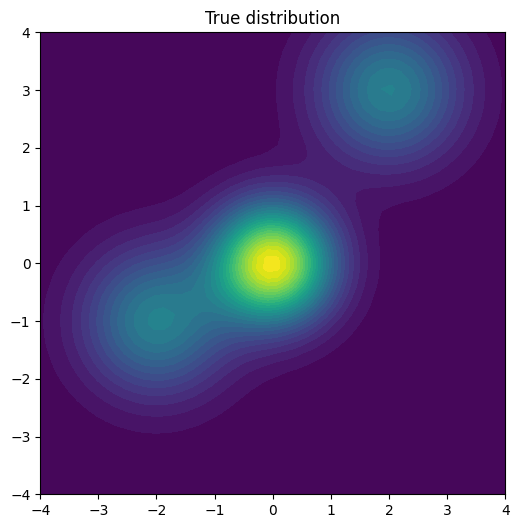

In [4]:
DIM = 2                # Particle dimension.
LIMS = [-4, 4, -4, 4]  # Environment limits.

# Mixture of Gaussians definition.
WEIGHTS = [1., 1.5, 1.]
MEANS = [[-2, -1], [0, 0], [2, 3]]
SIGMAS = [0.75, 0.5, 0.75]

MEANS = [np.array(mu) for mu in MEANS]
SIGMAS = [sig * np.eye(len(mu)) for mu, sig in zip(MEANS, SIGMAS)]

# Create the mixture of Gaussians.
p_x = dist.Mixture(MEANS, SIGMAS, WEIGHTS)

# Visualize the mixture of Gaussians.
plt.figure(figsize=(6, 6))
plt.title("True distribution")
plot_gaussian(p_x, LIMS);

In [5]:
# Setup Stein
K = 50                 # Number of particles.
LR = 0.1               # Learning rate at which to step the particles.
RBF_SIGMA = 0.2        # Kernel bandwidth (in practice, it's a good idea to set this with the Median Heuristic).

init_particles = torch.FloatTensor(K, DIM).uniform_(*LIMS[:2])
rbf_kernel = RBFMedianKernel(sigma=RBF_SIGMA)

## Running SVGD

Now we will create the `SVGD` object and run the optimization. Any PyTorch optimizer can be used to step the particles.

Iteration 0
Iteration 10
Iteration 20
Iteration 30
Iteration 40
Iteration 50
Iteration 60
Iteration 70
Iteration 80
Iteration 90
Total time: 1.226393699645996 s
Average time per iteration: 0.012263936996459961 s


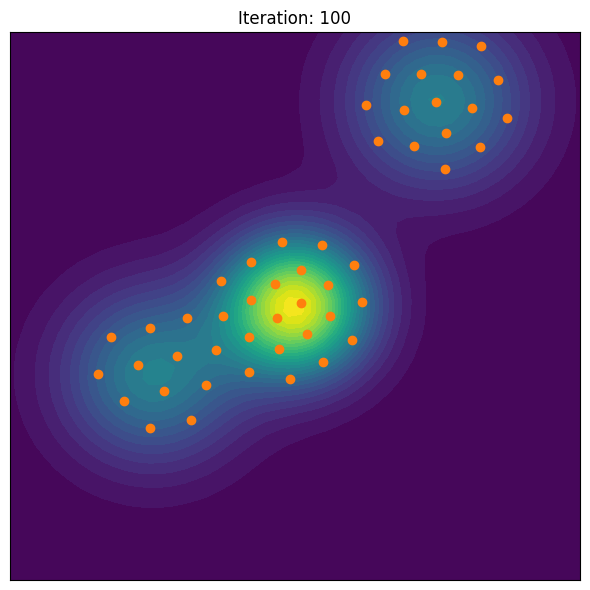

In [6]:
iters = 100  # Number of iterations to run.
ALPHA = 1.   # Repulsive force multiplier for Stein. Turning this to zero will let particles collapse to the optimal.
# Plotting
print_freq = 10
OUTPUT_PATH = "../output"  # Where the intermediate images for each iteration will be saved.
SAVE_PLOTS = True          # Set to False to not save the images.
os.makedirs(OUTPUT_PATH, exist_ok=True)

# Save this for plotting the particles.
px_pts = p_x.eval_grid(LIMS)

# Create the solver. The log likelihood is the log PDF of the mixture of Gaussians.
stein = SVGD(init_particles, p_x.log_pdf, rbf_kernel, alpha=ALPHA)

# Create the optimizer. This will control how the particles are updated.
# optim = torch.optim.SGD([stein.optim_parameters()], lr=LR)
optim = torch.optim.Adam([stein.optim_parameters()], lr=LR)

total_time = 0

if SAVE_PLOTS:
    # Plot the initial particles.
    plt.figure(99, figsize=(6, 6))
    plt.cla()
    plt.clf()
    plot_particles(plt.gca(), stein.particles().numpy(), px_pts,
                   lims=LIMS, title="Iteration: 0")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_PATH, f"iteration_{0:03}.jpg"))

for it in range(iters):
    start = time.time()
    # Update Stein VI particles.
    optim.zero_grad()
    stein.update()  # This populates the particle gradients using the Stein update equation.
    optim.step()    # This steps the particles according to the Stein update.

    total_time += time.time() - start

    if SAVE_PLOTS:
        # Plot, if requested.
        plt.cla()
        plt.clf()
        plot_particles(plt.gca(), stein.particles().numpy(), px_pts,
                       lims=LIMS, title="Iteration: {}".format(it + 1))
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_PATH, f"iteration_{(it + 1):03}.jpg"))

    if it % print_freq == 0:
        print("Iteration", it)

print("Total time:", total_time, "s")
print("Average time per iteration:", total_time / iters, "s")

If you ran with `SAVE_PLOTS = True`, you can find the particles at each iteration visualized in the `output/` folder.